## Use 8 regions to predict the other two regions
### - using GO model and LM
#### Jianfeng Ke
#### 03/22/2024

In [1]:
# import pytorch libraries
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from torch_geometric.deprecation import deprecated

import os
import csv
import copy
import math
import time
import random
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse
from decimal import Decimal
from scipy import stats
from scipy.stats import norm
from scipy.stats import spearmanr
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

In [2]:
# initial settings
# train the model on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

region_pick = ['Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia', 
               'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus', 'Hypothalamus', 
               'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra']

# name difference
def find_allen_name(gtex_region):
    if gtex_region=='Cerebellar_Hemisphere':
        allen_name = 'Cerebellum'
    elif gtex_region=='Frontal_Cortex_BA9':
        allen_name = 'Cortex'
    else:
        allen_name = gtex_region
        
    return allen_name

# settings
all_ids = ['10021', '12876', '14380', '15496', '15697', '9861']

# path
allen_data_path = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/data/allen_data/allen/'
save_path = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/data/allen_data/quantile_normalized_allen/'

GeneExpression_allen_dict = {}
# iterate over all 6 subjects
for i in range(len(all_ids)):
    donor = all_ids[i]
    file_name = save_path + "normalized_expr_" + donor + ".csv"
    normalized_mat = pd.read_csv(file_name, header = 0)
    normalized_mat = normalized_mat.set_index('gene_symbol')
    GeneExpression_allen_dict[donor] = normalized_mat
    
    
ontology_path = allen_data_path + 'normalized_microarray_donor' + '9861' + '/Ontology.csv'
ontology = pd.read_csv(ontology_path, header = 0)
# From the ontology file, find the sub-regions in allen under gtex region
gtex_map_path = allen_data_path + "map_gtex_structure.txt"
gTex_map_dict = {}
print("Total number of regions in allen ontology:", ontology.shape[0])
for i in open(gtex_map_path):
    i = i.strip().split("\t")
    gtex_region = i[0].strip()
    allen_region = i[1].strip()
    if((allen_region == "none?") | (allen_region == 'pituitary body')):
        continue
    covered_allen_region = ontology.loc[(ontology['name']==allen_region) | ontology['structure_id_path'].str.startswith(ontology.loc[ontology['name']==allen_region, 'structure_id_path'].values[0]), 'id']
    gTex_map_dict[gtex_region] = covered_allen_region.tolist()
    print(gtex_region, "-->", allen_region, ";  number of regions in allen:", len(covered_allen_region))
print("\n")
    
    
intersected_region = GeneExpression_allen_dict['9861'].columns.tolist()
used_intersected_region_dict = {}
# unseen_intersected_region_dict = {}
for gtex_region, covered_allen_region in gTex_map_dict.items():
    used_region_list = [x for x in intersected_region if int(x) in covered_allen_region]
    used_intersected_region_dict[gtex_region] = used_region_list
    print(gtex_region, " # regions expired:", len(used_region_list))
num_used_region = sum(len(value) for value in used_intersected_region_dict.values())
print("Total number of intersected region between allen and gtex:", len(intersected_region))
print("Total number of used allen region for generating regions for gtex:", num_used_region)
print("Total number of unseen allen regions when generating regions for gtex:", len(intersected_region)-num_used_region)
print("\n")


# read the summarized allen data (in gtex format) into a dictionary
save_path = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/data/allen_data/quantile_normalized_allen/'
# find the file and read it into a dictionary
summarized_gtex_dict = {}
for file_name in os.listdir(save_path):
    if file_name.endswith('-gtex.txt'):
        key = file_name.split('-gtex.txt')[0]
        file_path = os.path.join(save_path, file_name)
        mat = pd.read_csv(file_path, sep='\t', index_col=0)
        #mat = mat.iloc[:-1]
        # Store the dataframe in the dictionary with the key
        summarized_gtex_dict[key] = mat
        

# Load gtex data
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/12052023/'
gt = pd.read_csv(data_dir+"new_normed_gtex_gtex_allen_gene.txt", low_memory=False, index_col=0, sep="\t")

# build a dictionary to count the freq of each subject 
sample_subject_list = gt.loc['subject'].tolist()
subject_count_dict = {}
for s in sample_subject_list:
    if s in subject_count_dict:
        subject_count_dict[s] = subject_count_dict[s] + 1
    else:
        subject_count_dict[s] = 1
# build a dictionary to count the freq of each region
sample_region_list = gt.loc['region'].tolist()
region_count_dict = {}
for s in sample_region_list:
    if s in region_count_dict:
        region_count_dict[s] = region_count_dict[s] + 1
    else:
        region_count_dict[s] = 1  
# find the subjects that have all 10 regions
pick_subject = [s for s, c in subject_count_dict.items() if c==10]
# build a dictionary for exp data for each subject in gtex who has all 10 brain regions
exp_gtex_dict = {}
for subject in pick_subject:
    submat = gt[gt.columns[gt.iloc[1]==subject]]
    submat.columns = submat.loc['region',:]
    submat = submat.iloc[2:,]
    submat.index.names = ['gene_id']
    submat = submat.sort_values(by=['gene_id'])
    submat = submat[region_pick]
    # And also, transform the dataframe in gtex from strings to numbers
    submat = submat.apply(pd.to_numeric, errors='ignore')
    # Take the average if more than 1 sample have the same gene names
    submat = submat.groupby(submat.index).mean()
    exp_gtex_dict[subject] = submat
# find 30 gtex subjects
sub_all_ids = list(exp_gtex_dict.keys())
    
    
# gene_module = pd.read_csv(allen_data_path+'41593_2015_BFnn4171_MOESM97_ESM.csv')
allen_gene_list = GeneExpression_allen_dict['9861'].index
gtex_gene_list = exp_gtex_dict['GTEX-N7MT'].index
overlapped_gene_list = [x for x in gtex_gene_list if x in allen_gene_list]  # 15044 genes here
# allen subject gene expression profile on the overlapped genes
exp_allen_dict = {}
for key, mat in GeneExpression_allen_dict.items():
    exp_allen_dict[key] = mat.loc[overlapped_gene_list]
# summarized gtex info for allen subjects on the overlapped genes
summ_gtex_info = {}
for key, mat in summarized_gtex_dict.items():
    summ_gtex_info[key] = mat.loc[overlapped_gene_list]
# rename the Cerebellum to Cerebellar_Hemisphere and Cortex to Frontal_Cortex_BA for allen people
for subject, mat in summ_gtex_info.items():
    mat.columns = exp_gtex_dict['GTEX-N7MT'].columns


# gene embeddings
g_emb_error = 0.035
g_emb_size = 2 ** 4
g_emb_path = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/ATG_91_103/'
g_emb_name = f'allen_gtex_gene_emb_all6subjects_size_{g_emb_size}_pearson_err_{g_emb_error}_intersected103.csv'
# np.savetxt(g_emb_path+g_emb_name, pretrain_g_emb, delimiter=',')
# read the pretrained gene embedding
pretrain_g_emb = np.genfromtxt(g_emb_path+g_emb_name, delimiter=',', dtype=np.float32)
import pickle
# Load the gene names from the file
with open(g_emb_path+g_emb_name+'_genenames.pkl', 'rb') as file:
    gene_emb_names_list = pickle.load(file)
    

# Build the edge list
# From the Ontology find the node relationship list
onto_file_path = 'normalized_microarray_donor10021/Ontology.csv'
onto_file_path = os.path.join(allen_data_path, onto_file_path)
ontology = pd.read_csv(onto_file_path)
ontology_id = ontology.loc[:, ['id', 'parent_structure_id']]
# set the parent node of 4005 to -1
ontology_id.iloc[0,1] = -1
ontology_id['parent_structure_id'] = ontology_id['parent_structure_id'].astype(int)
# View the nodes in a hierarchical way
node_child = [int(x) for x in intersected_region]
all_node = []
for i in range(1,20):
    if i==1:
        print(f"level {i}: {len(node_child)}")
        print(node_child)
        all_node.append(node_child)
    if len(node_child)==1:
        break
    if i!=1:
        node_parent = []
        for node in node_child:
            pos = ontology_id['id'].index[ontology_id['id']==node]
            # skip if it's already the ancestor
            if len(pos)==0: continue
            parent = ontology_id['parent_structure_id'][pos].values[0]
            node_parent.append(parent)
        node_parent = set(node_parent)
        node_child = [x for x in node_parent]
        print(f"level {i}: {len(node_child)}")
        print(node_child)
        all_node.append(node_child)
repeated_nodes = [x for y in all_node for x in y]
pick_nodes = set(repeated_nodes)
print(f"There are {len(pick_nodes)} nodes in total")

pick_nodes = [x for x in pick_nodes]
pick_nodes.sort()
# exclude the ancestor node (4005) and the '-1' node
intersected_nodes_child = pick_nodes[2:]
child_nodes_chr = list(exp_allen_dict['9861'].columns)
child_nodes = [int(x) for x in child_nodes_chr]
# append other hyper-level nodes to the pick_nodes
for x in intersected_nodes_child:
    if x not in child_nodes:
        child_nodes.append(x)
# find the parent nodes for the pick_nodes
parent_nodes = []
for x in child_nodes:
    pos = ontology_id['id'].index[ontology_id['id']==x][0]
    parent = ontology_id['parent_structure_id'][pos]
    parent_nodes.append(parent)
    
for _ in range(len(parent_nodes)):
    length = len(parent_nodes)
    for i in range(length):
        cid = child_nodes[i]
        pid = parent_nodes[i]
        if pid!=4005:
            # find how many children this parent node has
            count1 = parent_nodes.count(pid)
            # if this count is more than one, we don't remove this node
            if count1 > 1:
                continue
            # if this parent node only has one child, we remove it
            else:
                # find the position of this parent node in the children node list
                pidx = child_nodes.index(pid)
                # find the grandparent
                ppid = parent_nodes[pidx]
                # remove this parent and directly connect the child to its grandparent
                child_nodes[pidx] = cid
                child_nodes.pop(i)
                parent_nodes.pop(i)
                break
    if len(parent_nodes)==length:
        break
        
# put the leaves at the beginning
initial_nodes_chr = list(exp_allen_dict['9861'].columns)
new_child_nodes = [int(x) for x in initial_nodes_chr]
new_parent_nodes = []
for x in child_nodes:
    if x not in new_child_nodes:
        new_child_nodes.append(x)
for x in new_child_nodes:
    new_parent_nodes.append(parent_nodes[child_nodes.index(x)])

# put all nodes together in order so we can re-assign node id
all_nodes = new_child_nodes.copy()
for x in new_parent_nodes:
    if x not in all_nodes:
        all_nodes.append(x)

# re-index all the nodes and all the dataframe
child_nodes_idx = []
parent_nodes_idx = []
for node in new_child_nodes:
    child_nodes_idx.append(all_nodes.index(node))
for node in new_parent_nodes:
    parent_nodes_idx.append(all_nodes.index(node))


# Model pre-setting
# train the model on GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# other settings
N_gene = len(exp_allen_dict['9861'])
N_node = len(child_nodes_idx)+1
n_node = len(intersected_region)
# define the edge list
# add edges between region nodes
edge_index_1 = [[child_nodes_idx[i], parent_nodes_idx[i]] for i in range(len(child_nodes_idx))]
edge_index_2 = [[parent_nodes_idx[i], child_nodes_idx[i]] for i in range(len(child_nodes_idx))]
edge_index = edge_index_1 + edge_index_2
for i in range(N_node):
    edge_index.append([i, i])

Total number of regions in allen ontology: 1839
Amygdala --> amygdala ;  number of regions in allen: 135
Anterior_cingulate_cortex_BA24 --> cingulate gyrus, frontal part ;  number of regions in allen: 7
Caudate_basal_ganglia --> caudate nucleus ;  number of regions in allen: 10
Cerebellum --> cerebellum ;  number of regions in allen: 95
Cortex --> frontal lobe ;  number of regions in allen: 87
Hippocampus --> hippocampal formation ;  number of regions in allen: 30
Hypothalamus --> hypothalamus ;  number of regions in allen: 176
Nucleus_accumbens_basal_ganglia --> nucleus accumbens ;  number of regions in allen: 3
Putamen_basal_ganglia --> putamen ;  number of regions in allen: 3
Substantia_nigra --> substantia nigra ;  number of regions in allen: 7


Amygdala  # regions expired: 6
Anterior_cingulate_cortex_BA24  # regions expired: 2
Caudate_basal_ganglia  # regions expired: 3
Cerebellum  # regions expired: 9
Cortex  # regions expired: 14
Hippocampus  # regions expired: 6
Hypothalamus  

### Functions to generate prediction from different models

In [10]:
# generate the LR model prediction for one region
def gen_lm(allen_mat_dict, gtex_mat_dict, y_region, x_region):
    allen_all_ids = ['10021', '12876', '14380', '15496', '15697', '9861']
    sub_all_ids = list(exp_gtex_dict.keys())
    lm_pred_dict = {}
    for subject in sub_all_ids:
        gtex_test_ids = [subject]
        sub_train_ids = [x for x in sub_all_ids if x not in gtex_test_ids]
        # build the x regions matrix
        train_dfs = [allen_mat_dict[key].loc[:,x_region] for key in allen_all_ids]
        Xtrain = pd.concat(train_dfs, axis=0, ignore_index=True)
        Xtrain = sm.add_constant(Xtrain)
        test_dfs = [gtex_mat_dict[key].loc[:,x_region] for key in gtex_test_ids]
        Xtest = pd.concat(test_dfs, axis=0, ignore_index=True)
        Xtest = sm.add_constant(Xtest)
        # build the y region
        train_preds = [allen_mat_dict[key].loc[:,y_region] for key in allen_all_ids]
        ytrain = pd.concat(train_preds, axis=0, ignore_index=True)
        test_preds = [gtex_mat_dict[key].loc[:,y_region] for key in gtex_test_ids]
        ytest = pd.concat(test_preds, axis=0, ignore_index=True)
        # build the lm model
        fmod = sm.OLS(ytrain, Xtrain).fit()
        # prediction
        train_pred = fmod.predict(Xtrain)
        test_pred = fmod.predict(Xtest)
        lm_pred_dict[subject] = test_pred
    lm_mat = pd.DataFrame.from_dict(lm_pred_dict)
    lm_mat.index = exp_gtex_dict['GTEX-1313W'].index
    
    return lm_mat

def gen_GO(t_epoch, f_epoch, region, gtex_exp_9_dict, pred_reg_id_list_idx):
    data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/ATG_91_103/Result/'
    pred_dict = {}
    if f_epoch==0:
        model_name = f'ATG_91_103_{region}_epoch_{t_epoch}_bf_architecture.pth'
        weights_name = f'ATG_91_103_{region}_epoch_{t_epoch}_bf_weights.pth'
    else:
        model_name = f'ATG_91_103_{region}_trainable_GNN_af_epoch_{t_epoch}_finetuning_epoch_{f_epoch}_architecture.pth'
        weights_name = f'ATG_91_103_{region}_trainable_GNN_af_epoch_{t_epoch}_finetuning_epoch_{f_epoch}_weights.pth'
    model = torch.load(data_dir+model_name, map_location=torch.device('cpu'))
    model.load_state_dict(torch.load(data_dir+weights_name, map_location=torch.device('cpu')))
    # running the model and get the prediction
    model.eval()
    for subject in sub_all_ids:
        gtex_exp_9 = gtex_exp_9_dict[subject]
        gen_tuple = torch.tensor(np.arange(N_gene), dtype=torch.long)
        x_reg_exp = torch.tensor(gtex_exp_9.values).float()
        with torch.no_grad():
            concat_pred = model(pred_reg_id_list_idx, gen_tuple, x_reg_exp, edge_index, N_gene).reshape(-1)
        pred_dict[subject] = concat_pred.detach().cpu()
    pred_mat = pd.DataFrame.from_dict(pred_dict)
    pred_mat.index = exp_gtex_dict['GTEX-1313W'].index
    
    return pred_mat

# generate the real expression data for the region
def gen_real(region):
    data = np.zeros((N_gene, len(sub_all_ids)))
    real_mat = pd.DataFrame(data, columns=sub_all_ids, index=exp_gtex_dict['GTEX-1313W'].index)
    for subject in sub_all_ids:
        real_mat[subject] = exp_gtex_dict[subject][region]
        
    return real_mat

# given two matrices, compute the mse and corr by gene
def metrics_by_gene(mat1, mat2):
    mse_list, cor_list = [], []
    for g in range(mat1.shape[0]):
        mat1_g_exp = np.array(mat1.iloc[g,])
        mat2_g_exp = np.array(mat2.iloc[g,])
        mse = np.mean((mat1_g_exp - mat2_g_exp) ** 2)
        cor, p = spearmanr(mat1_g_exp, mat2_g_exp)
        mse_list.append(mse)
        cor_list.append(cor)
    
    return mse_list, cor_list

### Missing region imputation through iteration

In [ ]:
# initial settings
t_epoch = 300
f_epoch = 500
iterative_epoch = 2

# record the time
start_time = time.time()

region_pick = ['Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia', 
               'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus', 'Hypothalamus', 
               'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra']
# pick several gtex regions to predict
pick_gtex_regions = [region_pick[0], region_pick[3]]

# generate the prediction from lm using 8 regions
lm_pred_dict = {}
for region in pick_gtex_regions:
    lm_mat = gen_lm(summ_gtex_info, exp_gtex_dict, region, [r for r in region_pick if r not in pick_gtex_regions])
    lm_pred_dict[region] = lm_mat
    
# generate the real expression data for each region in pick_gtex_regions
real_exp_dict = {}
for region in pick_gtex_regions:
    real_exp_dict[region] = gen_real(region)

# generate the initial input for GO model
iterative_pred_dict = {}
for pred_region in pick_gtex_regions:
    gtex_exp_9_dict = {}
    explan_regions = [r for r in pick_gtex_regions if r!=pred_region]
    for sub, mat in exp_gtex_dict.items():
        gtex_exp_9_dict[sub] = mat.drop(pred_region, axis=1)
        for region in explan_regions:
            gtex_exp_9_dict[sub][region] = lm_pred_dict[region][sub]
    iterative_pred_dict[pred_region] = gtex_exp_9_dict
    
# create lists for the errors
mse_list_dict, cor_list_dict = {}, {}
exp_mse_dict, exp_cor_dict = {}, {}
for pred_region in pick_gtex_regions:
    mse_list_dict[pred_region], cor_list_dict[pred_region] = [], []
    exp_mse_dict[pred_region], exp_cor_dict[pred_region] = 0, 0

# compute the initial error
for pred_region in pick_gtex_regions:
    mse_list, cor_list = metrics_by_gene(real_exp_dict[pred_region], lm_pred_dict[pred_region])
    avg_mse = np.mean(mse_list)
    avg_cor = np.mean(cor_list)
    mse_list_dict[pred_region].append(avg_mse)
    cor_list_dict[pred_region].append(avg_cor)
    print(f"Epoch 0 initial avg errors by genes on {pred_region}: MSE: {avg_mse}, Spearman correlation: {avg_cor}")
print("")

# compute the expected error
for pred_region in pick_gtex_regions:
    # find the predicted region and indices
    nodes_for_pred_gtex_region = used_intersected_region_dict[find_allen_name(pred_region)]
    nodes_for_pred_gtex_region_idx = [new_child_nodes.index(int(x)) for x in nodes_for_pred_gtex_region]
    gtex_exp_9_dict = {}
    for sub, mat in exp_gtex_dict.items():
        gtex_exp_9_dict[sub] = mat.drop(pred_region, axis=1)
    pred_mat = gen_GO(t_epoch, f_epoch, pred_region, gtex_exp_9_dict, nodes_for_pred_gtex_region_idx)
    mse_list, cor_list = metrics_by_gene(real_exp_dict[pred_region], pred_mat)
    exp_avg_mse = np.mean(mse_list)
    exp_avg_cor = np.mean(cor_list)
    exp_mse_dict[pred_region] = exp_avg_mse
    exp_cor_dict[pred_region] = exp_avg_cor
    print(f"Expected avg errors by genes on {pred_region}: MSE: {exp_avg_mse}, Spearman correlation: {exp_avg_cor}")
print("")
  
for e in range(iterative_epoch):
    for pred_region in pick_gtex_regions:
        # find the iterative result from last iteration
        gtex_exp_9_dict = iterative_pred_dict[pred_region]
        # find the predicted region and indices
        nodes_for_pred_gtex_region = used_intersected_region_dict[find_allen_name(pred_region)]
        nodes_for_pred_gtex_region_idx = [new_child_nodes.index(int(x)) for x in nodes_for_pred_gtex_region]
        # iterate over all 30 subjects
        pred_mat = gen_GO(t_epoch, f_epoch, pred_region, gtex_exp_9_dict, nodes_for_pred_gtex_region_idx)
        # compute the mse and spearman correlation
        mse_list, cor_list = metrics_by_gene(real_exp_dict[pred_region], pred_mat)
        avg_mse = np.mean(mse_list)
        avg_cor = np.mean(cor_list)
        mse_list_dict[pred_region].append(avg_mse)
        cor_list_dict[pred_region].append(avg_cor)
        # print the result
        print(f"Iterative epoch {e + 1} avg errors by genes: MSE: {avg_mse}, Spearman correlation: {avg_cor}")
        # save the result
        gtex_exp_9_dict = {}
        explan_regions = [r for r in pick_gtex_regions if r!=pred_region]
        for sub, mat in exp_gtex_dict.items():
            gtex_exp_9_dict[sub] = mat.drop(pred_region, axis=1)
            for region in explan_regions:
                gtex_exp_9_dict[sub][region] = pred_mat[sub]
        iterative_pred_dict[pred_region] = gtex_exp_9_dict
    print("")

In [ ]:
# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 8)) 
x_values = range(0, (iterative_epoch+1))
colors = ['blue', 'orange', 'green']

for i in range(len(pick_gtex_regions)):
    pred_region = pick_gtex_regions[i]
    mse_list = mse_list_dict[pred_region]
    cor_list = cor_list_dict[pred_region]
    exp_mse = exp_mse_dict[pred_region]
    exp_cor = exp_cor_dict[pred_region]
    axs[0].plot(x_values, mse_list, color=colors[i], marker='o', linestyle='-', label=pred_region)
    axs[0].axhline(y=exp_mse, color=colors[i], linestyle='--')
    axs[0].set_ylabel('MSE')
    axs[0].set_title('Missing region imputation using GO + LM')
    axs[0].set_xticks(x_values)
    axs[0].set_ylim(0, 1)
    axs[1].plot(x_values, cor_list, color=colors[i], marker='o', linestyle='-', label=pred_region)
    axs[1].axhline(y=exp_cor, color=colors[i], linestyle='--')
    axs[1].set_ylabel('Spearman correlation')
    axs[1].set_xlabel('Iteration')
    axs[1].set_xticks(x_values)
    axs[1].set_ylim(0, 1)
axs[0].legend()
axs[1].legend()
plt.show()

### Missing region imputation error comparison

In [ ]:
region_pick = ['Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia', 
               'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus', 'Hypothalamus', 
               'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra']
t_epoch=300
f_epoch=500

# mr stands for missing region, pr stands for predicted region
def missing_one_predict_one(mr, pr):
    # linear regression model prediction for the missing region and the predicted region
    lm_pr_mat = gen_lm(summ_gtex_info, exp_gtex_dict, pr, [r for r in region_pick if r not in [mr, pr]])
    lm_mr_mat = gen_lm(summ_gtex_info, exp_gtex_dict, mr, [r for r in region_pick if r not in [mr, pr]])
    # real expression data
    real_lm = gen_real(pr)
    # expected prediction from GO model if we have the missing region
    nodes_for_pred_gtex_region = used_intersected_region_dict[find_allen_name(pr)]
    nodes_for_pred_gtex_region_idx = [new_child_nodes.index(int(x)) for x in nodes_for_pred_gtex_region]
    gtex_exp_9_dict = {}
    for sub, mat in exp_gtex_dict.items():
        gtex_exp_9_dict[sub] = mat.drop(pr, axis=1)
    exp_go_mat = gen_GO(t_epoch, f_epoch, pr, gtex_exp_9_dict, nodes_for_pred_gtex_region_idx)
    # LM+GO prediction
    gtex_exp_9_dict = {}
    for sub, mat in exp_gtex_dict.items():
        gtex_exp_9_dict[sub] = mat.drop(pr, axis=1)
        gtex_exp_9_dict[sub][mr] = lm_mr_mat[sub]
    pred_go_mat = gen_GO(t_epoch, f_epoch, pr, gtex_exp_9_dict, nodes_for_pred_gtex_region_idx)
    # compute the error
    lm_mse_list, lm_cor_list = metrics_by_gene(real_lm, lm_pr_mat)
    lm_avg_mse, lm_avg_cor = np.mean(lm_mse_list), np.mean(lm_cor_list)
    exp_mse_list, exp_cor_list = metrics_by_gene(real_lm, exp_go_mat)
    exp_avg_mse, exp_avg_cor = np.mean(exp_mse_list), np.mean(exp_cor_list)
    pred_mse_list, pred_cor_list = metrics_by_gene(real_lm, pred_go_mat)
    pred_avg_mse, pred_avg_cor = np.mean(pred_mse_list), np.mean(pred_cor_list)
    
    return lm_avg_mse, lm_avg_cor, pred_avg_mse, pred_avg_cor, exp_avg_mse, exp_avg_cor

lm_avg_mse, lm_avg_cor, pred_avg_mse, pred_avg_cor, exp_avg_mse, exp_avg_cor = missing_one_predict_one(region_pick[2], region_pick[8])

In [ ]:
def plot_filled_circle(myplt, radius, color):
    theta = np.linspace(0, 2*np.pi, 100)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    myplt.fill(x, y, color)
plt.figure(figsize=(6, 6))
plot_filled_circle(plt, exp_avg_cor, 'blue')
plot_filled_circle(plt, pred_avg_cor, 'yellow')
plot_filled_circle(plt, lm_avg_cor, 'red')
# Add main title and subtitle
plt.suptitle("MSE comparison plots, i-j stands for missing region i and predict region j\n" + 
             "Region list: 'Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia',\n" + 
             "'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus',\n" + 
             "'Hypothalamus', 'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra'", fontsize=8)
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-2, 2)
plt.ylim(-2, 2)

In [ ]:
# def plot_filled_circle(myplt, radius, color):
#     theta = np.linspace(0, 2*np.pi, 100)
#     x = radius * np.cos(theta)
#     y = radius * np.sin(theta)
#     myplt.fill(x, y, color)
    
# # Create a figure and subplots
# fig, axs = plt.subplots(10, 10, figsize=(30, 30))  # 2 rows, 2 columns
# for i in range(10):
#     for j in range(10):
#         if i != j:
#             lm_avg_mse, lm_avg_cor, pred_avg_mse, pred_avg_cor, exp_avg_mse, exp_avg_cor = missing_one_predict_one(region_pick[i], region_pick[j])
#             plot_filled_circle(axs[i, j], lm_avg_mse, 'red')
#             plot_filled_circle(axs[i, j], pred_avg_mse, 'yellow')
#             plot_filled_circle(axs[i, j], exp_avg_mse, 'blue')
#         axs[i, j].set_title(f'{i+1}-{j+1}')
#         axs[i, j].set_xlim(-1, 1)
#         axs[i, j].set_ylim(-1, 1)
#         axs[i, j].yaxis.set_visible(False)
#         if i == 9:
#             axs[i, j].xaxis.set_visible(True)
#         if j == 0:
#             axs[i, j].yaxis.set_visible(True)
# plt.suptitle("MSE comparison plots, i-j stands for missing region i and predict region j\n" + 
#              "Region list: 'Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia',\n" + 
#              "'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus',\n" + 
#              "'Hypothalamus', 'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra'", fontsize=25)
# plt.subplots_adjust(wspace=0, hspace=0)
# # plt.tight_layout()
# plt.show()

In [ ]:
# def plot_filled_circle(myplt, radius, color):
#     theta = np.linspace(0, 2*np.pi, 100)
#     x = radius * np.cos(theta)
#     y = radius * np.sin(theta)
#     myplt.fill(x, y, color)
    
# # Create a figure and subplots
# fig, axs = plt.subplots(10, 10, figsize=(30, 30))  # 2 rows, 2 columns
# for i in range(10):
#     for j in range(10):
#         if i != j:
#             lm_avg_mse, lm_avg_cor, pred_avg_mse, pred_avg_cor, exp_avg_mse, exp_avg_cor = missing_one_predict_one(region_pick[i], region_pick[j])
#             plot_filled_circle(axs[i, j], exp_avg_cor, 'blue')
#             plot_filled_circle(axs[i, j], pred_avg_cor, 'yellow')
#             plot_filled_circle(axs[i, j], lm_avg_cor, 'red')
#         axs[i, j].set_title(f'{i+1}-{j+1}')
#         axs[i, j].set_xlim(-1, 1)
#         axs[i, j].set_ylim(-1, 1)
#         axs[i, j].yaxis.set_visible(False)
#         if i == 9:
#             axs[i, j].xaxis.set_visible(True)
#         if j == 0:
#             axs[i, j].yaxis.set_visible(True)
# plt.suptitle("Spearman correlation comparison plots, i-j stands for missing region i and predict region j\n" + 
#              "Region list: 'Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia',\n" + 
#              "'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus',\n" + 
#              "'Hypothalamus', 'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra'", fontsize=25)
# plt.subplots_adjust(wspace=0, hspace=0)
# # plt.tight_layout()
# plt.show()

### Expand the analysis on subjects with one or more missing region

In [3]:
# Load gtex data
data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/12052023/'
gt = pd.read_csv(data_dir+"new_normed_gtex_gtex_allen_gene.txt", low_memory=False, index_col=0, sep="\t")
region_pick = ['Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia', 
               'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus', 'Hypothalamus', 
               'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra']

# build a dictionary to count the freq of each subject 
sample_subject_list = gt.loc['subject'].tolist()
subject_region_mat = pd.DataFrame(np.zeros((len(set(sample_subject_list)), len(region_pick)), dtype=int))
subject_region_mat.index = sorted(set(sample_subject_list))
subject_region_mat.columns = region_pick
for i in range(gt.shape[1]):
    region = gt.loc['region'][i]
    subject = gt.loc['subject'][i]
    region_idx = region_pick.index(region)
    subject_idx = subject_region_mat.index.tolist().index(subject)
    subject_region_mat.iloc[subject_idx, region_idx] = 1

count_mat_9 = pd.DataFrame(np.zeros((1, len(region_pick)), dtype=int))
count_mat_9.columns = region_pick
for i in range(subject_region_mat.shape[0]):
    info = subject_region_mat.iloc[i]
    if info.sum()==9:
        for j in range(len(info)):
            if info[j]==0:
                count_mat_9.iloc[0,j] = count_mat_9.iloc[0,j] + 1
        
count_mat_8 = pd.DataFrame(np.zeros((len(region_pick), len(region_pick)), dtype=int))
count_mat_8.columns = region_pick
count_mat_8.index = region_pick
for i in range(subject_region_mat.shape[0]):
    info = subject_region_mat.iloc[i]
    if info.sum()==8:
        for j in range(len(info)):
            if info[j]==0:
                for k in range((j+1), len(info)):
                    if info[k]==0:
                        count_mat_8.iloc[j,k] = count_mat_8.iloc[j,k] + 1

In [4]:
count_mat_9.values

array([[ 8, 10,  1,  3,  1,  3,  2,  1,  4,  9]])

In [5]:
count_mat_8.values

array([[0, 4, 0, 1, 1, 2, 1, 0, 1, 7],
       [0, 0, 1, 0, 2, 1, 0, 0, 0, 3],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 4],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [6]:
subject_region_mat

,Amygdala,Anterior_cingulate_cortex_BA24,Caudate_basal_ganglia,Cerebellar_Hemisphere,Frontal_Cortex_BA9,Hippocampus,Hypothalamus,Nucleus_accumbens_basal_ganglia,Putamen_basal_ganglia,Substantia_nigra
GTEX-1192X,0,0,1,0,1,0,1,1,1,0
GTEX-11DXW,0,1,1,0,0,1,0,1,1,0
GTEX-11DXY,0,0,1,1,1,0,1,1,1,0
GTEX-11DYG,0,0,1,1,1,0,1,1,1,0
GTEX-11DZ1,0,1,1,1,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
GTEX-ZUA1,0,1,1,1,1,1,1,1,1,0
GTEX-ZV68,0,0,1,0,1,0,0,1,1,1
GTEX-ZVT3,0,1,1,1,1,0,1,1,1,0
GTEX-ZVZQ,1,1,1,1,1,1,1,1,1,0


In [7]:
def gen_real_missing(include_subject, pred_region):
    exp_dict = {}
    for i in range(gt.shape[1]):
        if gt.loc['region'][i]==pred_region:
            if gt.loc['subject'][i] in include_subject:
                exp_dict[gt.loc['subject'][i]] = [float(x) for x in gt.iloc[:,i].tolist()[2:]]
    pred_mat = pd.DataFrame(exp_dict)
    pred_mat.index = gt.index[2:]
    return pred_mat

def gen_lm_missing(include_subject, pred_region):
    y_region = pred_region
    allen_all_ids = ['10021', '12876', '14380', '15496', '15697', '9861']
    lm_pred_dict = {}
    for subject in include_subject:
        x_region = [r for r in region_pick if subject_region_mat.loc[subject, r]==1 if r!=pred_region]
        # build the x regions matrix
        train_dfs = [summ_gtex_info[key].loc[:,x_region] for key in allen_all_ids]
        Xtrain = pd.concat(train_dfs, axis=0, ignore_index=True)
        Xtrain = sm.add_constant(Xtrain)
        pick_col = [i for i in range(gt.shape[1]) if gt.loc['subject'][i]==subject]
        Xtest = gt.iloc[:,pick_col]
        Xtest.columns = Xtest.loc['region']
        Xtest = Xtest.drop(['region', 'subject'])
        Xtest = Xtest.loc[:,x_region]
        Xtest = Xtest.apply(pd.to_numeric)
        Xtest = sm.add_constant(Xtest)
        # build the y region
        train_preds = [summ_gtex_info[key].loc[:,y_region] for key in allen_all_ids]
        ytrain = pd.concat(train_preds, axis=0, ignore_index=True)
        # build the lm model
        fmod = sm.OLS(ytrain, Xtrain).fit()
        # prediction
        pred = fmod.predict(Xtest)
        lm_pred_dict[subject] = pred
    lm_mat = pd.DataFrame.from_dict(lm_pred_dict)
    lm_mat.index = gt.index[2:]
    return lm_mat

def gen_GO_missing(t_epoch, f_epoch, include_subject, pred_region):
    data_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/ATG_91_103/Result/'
    allen_all_ids = ['10021', '12876', '14380', '15496', '15697', '9861']
    if f_epoch==0:
        model_name = f'ATG_91_103_{pred_region}_epoch_{t_epoch}_bf_architecture.pth'
        weights_name = f'ATG_91_103_{pred_region}_epoch_{t_epoch}_bf_weights.pth'
    else:
        model_name = f'ATG_91_103_{pred_region}_trainable_GNN_af_epoch_{t_epoch}_finetuning_epoch_{f_epoch}_architecture.pth'
        weights_name = f'ATG_91_103_{pred_region}_trainable_GNN_af_epoch_{t_epoch}_finetuning_epoch_{f_epoch}_weights.pth'
    model = torch.load(data_dir+model_name, map_location=torch.device('cpu'))
    model.load_state_dict(torch.load(data_dir+weights_name, map_location=torch.device('cpu')))
    # find the predicted region and indices
    nodes_for_pred_gtex_region = used_intersected_region_dict[find_allen_name(pred_region)]
    nodes_for_pred_gtex_region_idx = [new_child_nodes.index(int(x)) for x in nodes_for_pred_gtex_region]
    # use lm model to fill other missing regions
    go_pred_dict = {}
    for subject in include_subject:
        other_9_region_dict = {}
        # these are the existing regions besides the predicted region
        x_region = [r for r in region_pick if subject_region_mat.loc[subject, r]==1 if r!=pred_region]
        for region in x_region:
            for i in range(gt.shape[1]):
                if ((gt.loc['region'][i]==region) & (gt.loc['subject'][i]==subject)):
                    other_9_region_dict[region] = pd.to_numeric(gt.iloc[2:,i])
        # these are the regions to fill with lm model
        fill_region = [r for r in region_pick if r not in x_region if r!=pred_region]
        # build the inputs for GO model
        if len(fill_region)!=0:
            # build the x regions matrix
            train_dfs = [summ_gtex_info[key].loc[:,x_region] for key in allen_all_ids]
            Xtrain = pd.concat(train_dfs, axis=0, ignore_index=True)
            Xtrain = sm.add_constant(Xtrain)
            pick_col = [i for i in range(gt.shape[1]) if gt.loc['subject'][i]==subject]
            Xtest = gt.iloc[:,pick_col]
            Xtest.columns = Xtest.loc['region']
            Xtest = Xtest.drop(['region', 'subject'])
            Xtest = Xtest.loc[:,x_region]
            Xtest = Xtest.apply(pd.to_numeric)
            Xtest = sm.add_constant(Xtest)
            for lm_region in fill_region:
                y_region = lm_region
                # build the y region
                train_preds = [summ_gtex_info[key].loc[:,y_region] for key in allen_all_ids]
                ytrain = pd.concat(train_preds, axis=0, ignore_index=True)
                # build the lm model
                fmod = sm.OLS(ytrain, Xtrain).fit()
                # prediction
                pred = fmod.predict(Xtest)
                other_9_region_dict[lm_region] = pred
        # build the inputs for GO model
        sorted_region = [r for r in region_pick if r!=pred_region]
        input_mat = pd.DataFrame.from_dict(other_9_region_dict)
        input_mat.index = gt.index[2:]
        input_mat = input_mat.loc[:,sorted_region]
        # run GO model
        gen_tuple = torch.tensor(np.arange(N_gene), dtype=torch.long)
        x_reg_exp = torch.tensor(input_mat.values).float()        
        with torch.no_grad():
            concat_pred = model(nodes_for_pred_gtex_region_idx, gen_tuple, x_reg_exp, edge_index, N_gene).reshape(-1)
        go_pred_dict[subject] = concat_pred.detach().cpu()
    # generate the final output
    pred_mat = pd.DataFrame.from_dict(go_pred_dict)
    pred_mat.index = gt.index[2:]
    
    return pred_mat

# generate the MICE prediction
def gen_mice_missing(include_subject, pred_region, missing_N):
    mice_result_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/Running_MICE/MICE_results/'
    data = np.zeros((N_gene, len(include_subject)))
    mice_mat = pd.DataFrame(data, columns=include_subject, index=gt.index[2:])
    for subject in include_subject:
        mice_csv = f'{subject}_{pred_region}_{missing_N}.csv'
        mice_pred = pd.read_csv(mice_result_dir+mice_csv, index_col=0)['prediction'].tolist()
        mice_mat[subject] = mice_pred
        
    return mice_mat

# generate the CP method prediction
def gen_cp_missing(include_subject, pred_region, missing_N):
    cp_result_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/R/02072024/CP_results/'
    data = np.zeros((N_gene, len(include_subject)))
    cp_mat = pd.DataFrame(data, columns=include_subject, index=gt.index[2:])
    for subject in include_subject:
        cp_csv = f'{subject}_{pred_region}_5_20_0.5_0.5.csv'
        cp_pred = pd.read_csv(cp_result_dir+cp_csv, index_col=0)['prediction'].tolist()
        cp_mat[subject] = cp_pred
        
    return cp_mat

# given two matrices, compute the mse and corr by gene
def metrics_by_gene(mat1, mat2):
    mse_list, cor_list = [], []
    for g in range(mat1.shape[0]):
        mat1_g_exp = np.array(mat1.iloc[g,])
        mat2_g_exp = np.array(mat2.iloc[g,])
        mse = np.mean((mat1_g_exp - mat2_g_exp) ** 2)
        cor, p = spearmanr(mat1_g_exp, mat2_g_exp)
        mse_list.append(mse)
        cor_list.append(cor)
    
    return mse_list, cor_list

#### Without PrediXcan

In [ ]:
epoch = 500
f_epoch = 500
save_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/src/Pytorch/02162024/ATG_10_103/Prediction/'

#dict_name = f'gtex_allen_region_bf_epoch_{epoch}.pickle'
#dict_name = f'gtex_allen_region_af_epoch_{epoch}_fepoch_{f_epoch}.pickle'
dict_name = f'gtex_allen_region_freeze_GNN_af_epoch_{epoch}_fepoch_{f_epoch}.pickle'

# Reading the pickled data from file
with open(save_dir+dict_name, 'rb') as f:
    gtex_allen_region_dict = pickle.load(f)
# read the allen dataset
dict_name = f'allen_dataset_dict.pickle'
with open(save_dir+dict_name, 'rb') as f:
    allen_dict = pickle.load(f)
    
# the number of subjects in gtex
n_gtex = len(gtex_allen_region_dict.keys())
# the list of gtex subjects
gtex_subject_list = list(gtex_allen_region_dict.keys())
# allen
n_allen = len(allen_dict.keys())
allen_subject_list = list(allen_dict.keys())
# find the gene list
gene_list = allen_dict[allen_subject_list[0]].index.tolist()

In [ ]:
pred_region = region_pick[0]

N = 6
t_epoch = 300
f_epoch = 500
go_mse_list_list, go_cor_list_list = [], []
lm_mse_list_list, lm_cor_list_list = [], []
mice_mse_list_list, mice_cor_list_list = [], []
cp_mse_list_list, cp_cor_list_list = [], []
n_subject = []
for missing_N in range(N):
    include_subject = [s for s in subject_region_mat.index if subject_region_mat.loc[s].sum()>=(10-missing_N) if subject_region_mat.loc[s,pred_region]==1]
    real_mat = gen_real_missing(include_subject, pred_region)
    # compute prediction
    go_mat = gen_GO_missing(t_epoch, f_epoch, include_subject, pred_region)
    lm_mat = gen_lm_missing(include_subject, pred_region)
    mice_mat = gen_mice_missing(include_subject, pred_region, 5)
    cp_mat = gen_cp_missing(include_subject, pred_region, 5)
    # compute loss
    go_mse_list, go_cor_list = metrics_by_gene(go_mat, real_mat)
    lm_mse_list, lm_cor_list = metrics_by_gene(lm_mat, real_mat)
    mice_mse_list, mice_cor_list = metrics_by_gene(mice_mat, real_mat)
    cp_mse_list, cp_cor_list = metrics_by_gene(cp_mat, real_mat)
    # save the results
    go_mse_list_list.append(go_mse_list)
    go_cor_list_list.append(go_cor_list)
    lm_mse_list_list.append(lm_mse_list)
    lm_cor_list_list.append(lm_cor_list)
    mice_mse_list_list.append(mice_mse_list)
    mice_cor_list_list.append(mice_cor_list)
    cp_mse_list_list.append(cp_mse_list)
    cp_cor_list_list.append(cp_cor_list)
    n_subject.append(len(include_subject))
    
# Calculate means
go_mse_means = [np.nanmean(mse_list) for mse_list in go_mse_list_list]
go_cor_means = [np.nanmean(cor_list) for cor_list in go_cor_list_list]
lm_mse_means = [np.nanmean(mse_list) for mse_list in lm_mse_list_list]
lm_cor_means = [np.nanmean(cor_list) for cor_list in lm_cor_list_list]
mice_mse_means = [np.nanmean(mse_list) for mse_list in mice_mse_list_list]
mice_cor_means = [np.nanmean(cor_list) for cor_list in mice_cor_list_list]
cp_mse_means = [np.nanmean(mse_list) for mse_list in cp_mse_list_list]
cp_cor_means = [np.nanmean(cor_list) for cor_list in cp_cor_list_list]

In [ ]:
# Create violin plots
plt.figure(figsize=(10, 6))
colors = ['#004c6d', '#50c878', '#6a0dad', '#ff6f61', '#ffd700']
# GO model
x_values = [f"X={i}, N={n_subject[i]}" for i in range(N) for _ in range(N_gene)]
y_values = [val for sublist in go_mse_list_list for val in sublist]
sns.violinplot(x=x_values, y=y_values, color=colors[0], alpha=0.5)
plt.plot([x for x in range(N)], go_mse_means, marker='o', color=colors[0], linestyle='-', markersize=10, label='GO')
for obj in plt.gca().collections[N:]:
    obj.set_alpha(0.5)
# lm
y_values = [val for sublist in lm_mse_list_list for val in sublist]
sns.violinplot(x=x_values, y=y_values, color=colors[1], alpha=0.5)
plt.plot([x for x in range(N)], lm_mse_means, marker='o', color=colors[1], linestyle='-', markersize=10, label='LM')
# mice
y_values = [val for sublist in mice_mse_list_list for val in sublist]
sns.violinplot(x=x_values, y=y_values, color=colors[2], alpha=0.5)
plt.plot([x for x in range(N)], mice_mse_means, marker='o', color=colors[2], linestyle='-', markersize=10, label='MICE')
# cp
y_values = [val for sublist in cp_mse_list_list for val in sublist]
sns.violinplot(x=x_values, y=y_values, color=colors[3], alpha=0.5)
plt.plot([x for x in range(N)], cp_mse_means, marker='o', color=colors[3], linestyle='-', markersize=10, label='CP (5)')

# modify the transparency
for obj in plt.gca().collections[:]:
    obj.set_alpha(0.5)
# Plot means for second set of violin plots
plt.title(f'{pred_region}')
plt.xlabel('Subjects with the number of missing regions less than or equals to X, number of subjects = N')
plt.ylabel('MSE')
plt.xticks(fontsize=8)
plt.ylim(0,2)
plt.legend(loc='lower center')
plt.show()

In [ ]:
# Create violin plots
plt.figure(figsize=(10, 6))
colors = ['#004c6d', '#50c878', '#6a0dad', '#ff6f61', '#ffd700']
# GO model
x_values = [f"X={i}, N={n_subject[i]}" for i in range(N) for _ in range(N_gene)]
y_values = [val for sublist in go_cor_list_list for val in sublist]
sns.violinplot(x=x_values, y=y_values, color=colors[0], alpha=0.5)
plt.plot([x for x in range(N)], go_cor_means, marker='o', color=colors[0], linestyle='-', markersize=10, label='GO')
for obj in plt.gca().collections[N:]:
    obj.set_alpha(0.5)
# lm
y_values = [val for sublist in lm_cor_list_list for val in sublist]
sns.violinplot(x=x_values, y=y_values, color=colors[1], alpha=0.5)
plt.plot([x for x in range(N)], lm_cor_means, marker='o', color=colors[1], linestyle='-', markersize=10, label='LM')
# mice
y_values = [val for sublist in mice_cor_list_list for val in sublist]
sns.violinplot(x=x_values, y=y_values, color=colors[2], alpha=0.5)
plt.plot([x for x in range(N)], mice_cor_means, marker='o', color=colors[2], linestyle='-', markersize=10, label='MICE')
# CP
y_values = [val for sublist in cp_cor_list_list for val in sublist]
sns.violinplot(x=x_values, y=y_values, color=colors[3], alpha=0.5)
plt.plot([x for x in range(N)], cp_cor_means, marker='o', color=colors[3], linestyle='-', markersize=10, label='CP (5)')

# modify the transparency
for obj in plt.gca().collections[:]:
    obj.set_alpha(0.5)
# Plot means for second set of violin plots
plt.title(f'{pred_region}')
plt.xlabel('Subjects with the number of missing regions less than or equals to X, number of subjects = N')
plt.ylabel('Spearman correlation')
plt.xticks(fontsize=8)
plt.ylim(-0.5,1)
plt.legend(loc='lower center')
plt.show()

### Expand the analysis on subjects with one or more missing region

In [8]:
def gen_predixcan(region):
    predixcan_dir = '/project/pi_rachel_melamed_uml_edu/Jianfeng/Allen/data/PrediXcan/result/'
    region_pick = ['Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia', 
                   'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus', 'Hypothalamus', 
                   'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra']
    predict_filename = 'mashr_Brain_' + region + '_predict.txt'
    summary_filename = 'mashr_Brain_' + region + '_summary.txt'
    predict_data = pd.read_csv(predixcan_dir+predict_filename, low_memory=False, index_col=0, sep="\t")
    summary_data = pd.read_csv(predixcan_dir+summary_filename, low_memory=False, sep="\t")
    # gene code to gene name dictionary
    gene_name_dict = {}
    for i in range(len(summary_data['gene'])):
        gene = summary_data['gene'][i]
        gene_name = summary_data['gene_name'][i]
        gene_name_dict[gene] = gene_name
    # match gene code to gene name
    predict_data.columns = predict_data.columns.map(gene_name_dict.get)
    # remove duplicate id column
    predict_data = predict_data.iloc[:, 1:]
    # predict_data = predict_data.rename(columns={predict_data.columns[0]: 'ID'})
    predict_data = predict_data.T

    # count number of overlapped genes
    set1 = set(overlapped_gene_list)
    set2 = set(predict_data.index.tolist())
    PrediXcan_gene_list = list(set1 & set2)
    predict_data = predict_data.loc[PrediXcan_gene_list]
    # remove duplicate genes
    predict_data = predict_data.groupby(predict_data.index).mean()
    PrediXcan_normed_df = predict_data.copy()

    # load gtex data of that region
    gtex_data = gt.loc[:, gt.iloc[0] == region]
    gtex_data = gtex_data.loc[predict_data.index].values.astype(float)
    for i in range(PrediXcan_normed_df.shape[0]):
        predixcan_value = predict_data.values[i]
        gtex_value_num = gtex_data[i]
        percentiles = norm.cdf(predixcan_value, loc=0, scale=1)
        mapped_data = np.percentile(gtex_value_num, percentiles * 100)
        PrediXcan_normed_df.iloc[i,:] = mapped_data
    
    return PrediXcan_normed_df

In [15]:
region_pick = ['Amygdala', 'Anterior_cingulate_cortex_BA24', 'Caudate_basal_ganglia', 
               'Cerebellar_Hemisphere', 'Frontal_Cortex_BA9', 'Hippocampus', 'Hypothalamus', 
               'Nucleus_accumbens_basal_ganglia', 'Putamen_basal_ganglia', 'Substantia_nigra']
pred_region = region_pick[9]
predixcan_matrix = gen_predixcan(pred_region)

N = 6
t_epoch = 300
f_epoch = 500
go_mse_list_list, go_cor_list_list = [], []
lm_mse_list_list, lm_cor_list_list = [], []
mice_mse_list_list, mice_cor_list_list = [], []
cp_mse_list_list, cp_cor_list_list = [], []
predixcan_mse_list_list, predixcan_cor_list_list = [], []
n_subject = []
p_subject = []
for missing_N in range(N):
    include_subject = [s for s in subject_region_mat.index if subject_region_mat.loc[s].sum()>=(10-missing_N) if subject_region_mat.loc[s,pred_region]==1]
    real_mat = gen_real_missing(include_subject, pred_region)
    go_mat = gen_GO_missing(t_epoch, f_epoch, include_subject, pred_region)
    lm_mat = gen_lm_missing(include_subject, pred_region)
    mice_mat = gen_mice_missing(include_subject, pred_region, 5)
    cp_mat = gen_cp_missing(include_subject, pred_region, 5)
    # find the overlapped subjects and genes with predixcan
    predixcan_subject = [x for x in include_subject if x in predixcan_matrix.columns]
    predixcan_gene = predixcan_matrix.index.tolist()
    predixcan_mat = predixcan_matrix[predixcan_subject]
    real_mat = real_mat[predixcan_subject].loc[predixcan_gene]
    go_mat = go_mat[predixcan_subject].loc[predixcan_gene]
    lm_mat = lm_mat[predixcan_subject].loc[predixcan_gene]
    mice_mat = mice_mat[predixcan_subject].loc[predixcan_gene]
    cp_mat = cp_mat[predixcan_subject].loc[predixcan_gene]
    # compute error for each model
    go_mse_list, go_cor_list = metrics_by_gene(go_mat, real_mat)
    lm_mse_list, lm_cor_list = metrics_by_gene(lm_mat, real_mat)
    mice_mse_list, mice_cor_list = metrics_by_gene(mice_mat, real_mat)
    cp_mse_list, cp_cor_list = metrics_by_gene(cp_mat, real_mat)
    predixcan_mse_list, predixcan_cor_list = metrics_by_gene(predixcan_mat, real_mat)
    # append the results
    go_mse_list_list.append(go_mse_list)
    go_cor_list_list.append(go_cor_list)
    lm_mse_list_list.append(lm_mse_list)
    lm_cor_list_list.append(lm_cor_list)
    mice_mse_list_list.append(mice_mse_list)
    mice_cor_list_list.append(mice_cor_list)
    cp_mse_list_list.append(cp_mse_list)
    cp_cor_list_list.append(cp_cor_list)
    predixcan_mse_list_list.append(predixcan_mse_list)
    predixcan_cor_list_list.append(predixcan_cor_list)
    n_subject.append(len(include_subject))
    p_subject.append(len(predixcan_subject))
    
# Calculate means
go_mse_means = [np.nanmean(mse_list) for mse_list in go_mse_list_list]
go_cor_means = [np.nanmean(cor_list) for cor_list in go_cor_list_list]
lm_mse_means = [np.nanmean(mse_list) for mse_list in lm_mse_list_list]
lm_cor_means = [np.nanmean(cor_list) for cor_list in lm_cor_list_list]
mice_mse_means = [np.nanmean(mse_list) for mse_list in mice_mse_list_list]
mice_cor_means = [np.nanmean(cor_list) for cor_list in mice_cor_list_list]
cp_mse_means = [np.nanmean(mse_list) for mse_list in cp_mse_list_list]
cp_cor_means = [np.nanmean(cor_list) for cor_list in cp_cor_list_list]
predixcan_mse_means = [np.nanmean(mse_list) for mse_list in predixcan_mse_list_list]
predixcan_cor_means = [np.nanmean(cor_list) for cor_list in predixcan_cor_list_list]

/tmp/ipykernel_491501/1565589383.py:137: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  cor, p = spearmanr(mat1_g_exp, mat2_g_exp)
/tmp/ipykernel_491501/1565589383.py:137: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  cor, p = spearmanr(mat1_g_exp, mat2_g_exp)
/tmp/ipykernel_491501/1565589383.py:137: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  cor, p = spearmanr(mat1_g_exp, mat2_g_exp)
/tmp/ipykernel_491501/1565589383.py:137: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  cor, p = spearmanr(mat1_g_exp, mat2_g_exp)
/tmp/ipykernel_491501/1565589383.py:137: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  cor, p = spearmanr(mat1_g_exp, mat2_g_exp)
/tmp/ipykernel_491501/1565589383.py:137: ConstantInputWarning: An input array is constant; the corre

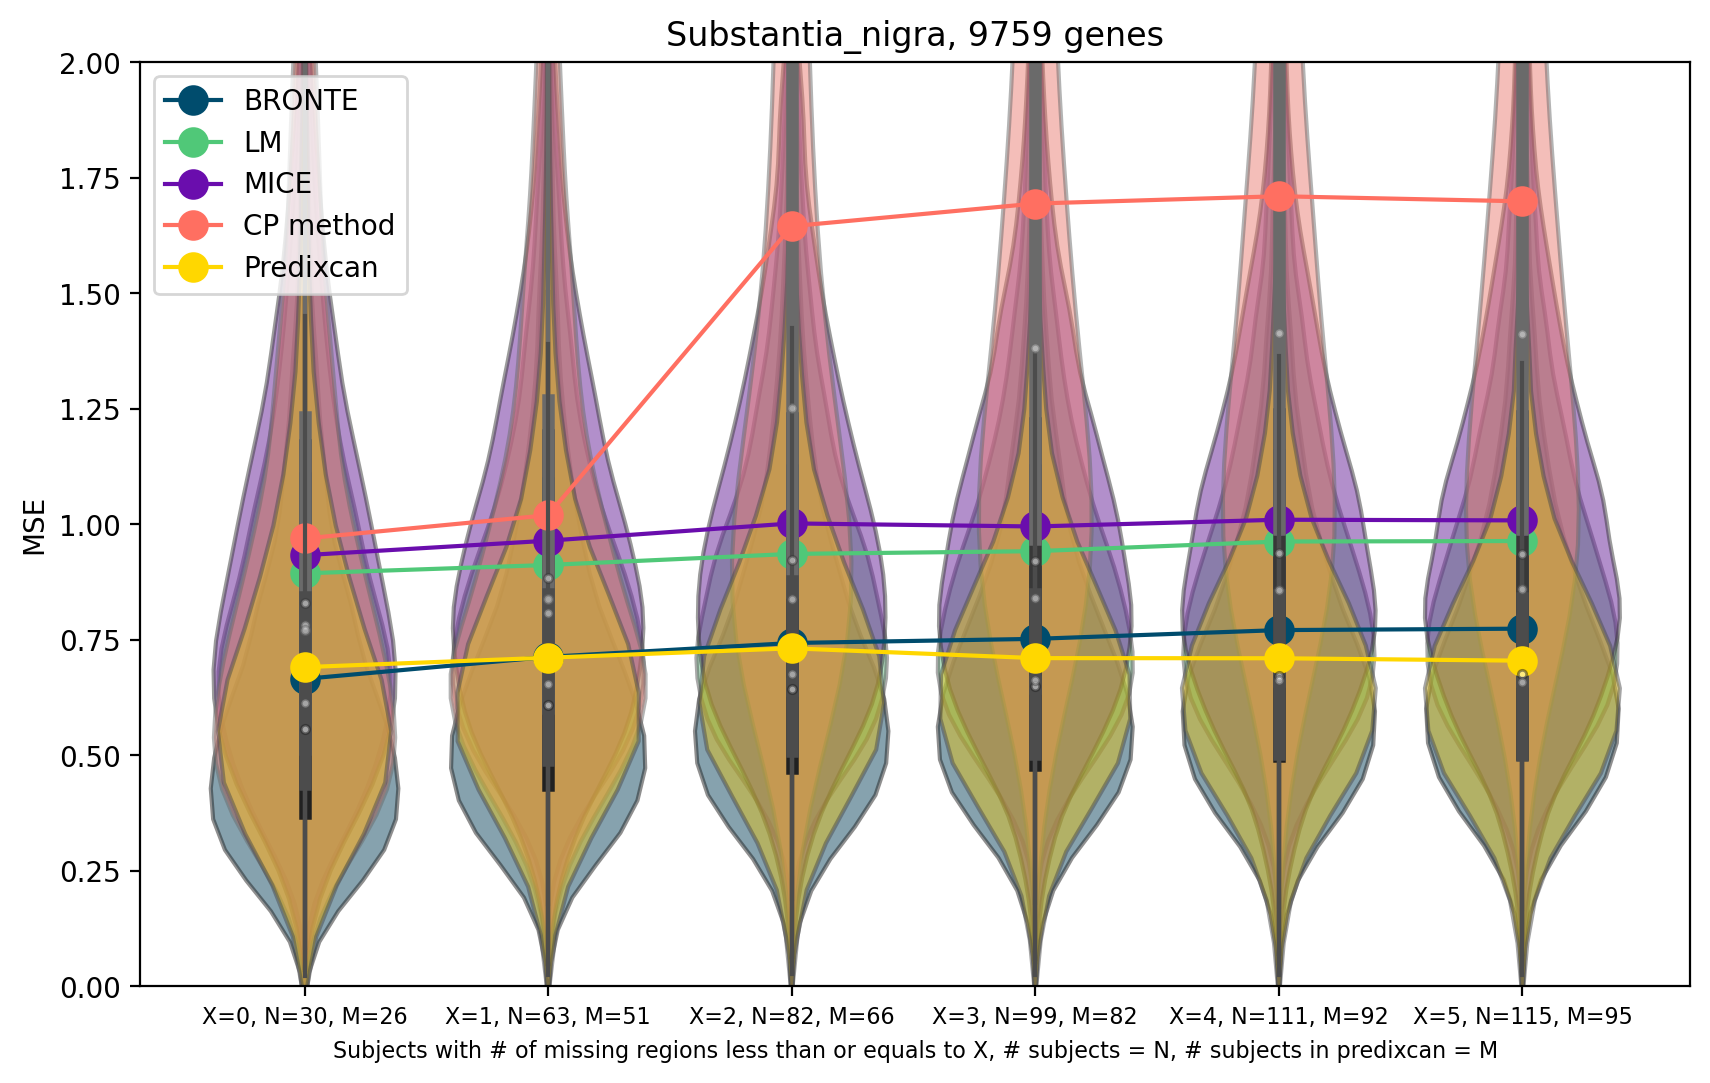

In [16]:
# Create violin plots
N_predixcan_gene = len(predixcan_matrix.index.tolist())
plt.figure(figsize=(10, 6), dpi=200)
colors = ['#004c6d', '#50c878', '#6a0dad', '#ff6f61', '#ffd700']
# GO model
x_values = [f"X={i}, N={n_subject[i]}, M={p_subject[i]}" for i in range(N) for _ in range(N_predixcan_gene)]
y_values = [val for sublist in go_mse_list_list for val in sublist]
sns.violinplot(x=x_values, y=y_values, color=colors[0], alpha=0.5)
plt.plot([x for x in range(N)], go_mse_means, marker='o', color=colors[0], linestyle='-', markersize=10, label='BRONTE')
# lm
y_values = [val for sublist in lm_mse_list_list for val in sublist]
sns.violinplot(x=x_values, y=y_values, color=colors[1], alpha=0.5)
plt.plot([x for x in range(N)], lm_mse_means, marker='o', color=colors[1], linestyle='-', markersize=10, label='LM')
# MICE
y_values = [val for sublist in mice_mse_list_list for val in sublist]
sns.violinplot(x=x_values, y=y_values, color=colors[2], alpha=0.5)
plt.plot([x for x in range(N)], mice_mse_means, marker='o', color=colors[2], linestyle='-', markersize=10, label='MICE')
# CP
y_values = [val for sublist in cp_mse_list_list for val in sublist]
sns.violinplot(x=x_values, y=y_values, color=colors[3], alpha=0.5)
plt.plot([x for x in range(N)], cp_mse_means, marker='o', color=colors[3], linestyle='-', markersize=10, label='CP method')
# Predixcan
y_values = [val for sublist in predixcan_mse_list_list for val in sublist]
sns.violinplot(x=x_values, y=y_values, color=colors[4], alpha=0.5)
plt.plot([x for x in range(N)], predixcan_mse_means, marker='o', color=colors[4], linestyle='-', markersize=10, label='Predixcan')

# modify the transparency
for obj in plt.gca().collections[:]:
    obj.set_alpha(0.5)
# Plot means for second set of violin plots
plt.title(f'{pred_region}, {len(predixcan_gene)} genes')
plt.xlabel('Subjects with # of missing regions less than or equals to X, # subjects = N, # subjects in predixcan = M', fontsize=8)
plt.ylabel('MSE')
plt.xticks(fontsize=8)
plt.ylim(0,2)
plt.legend()
plt.show()

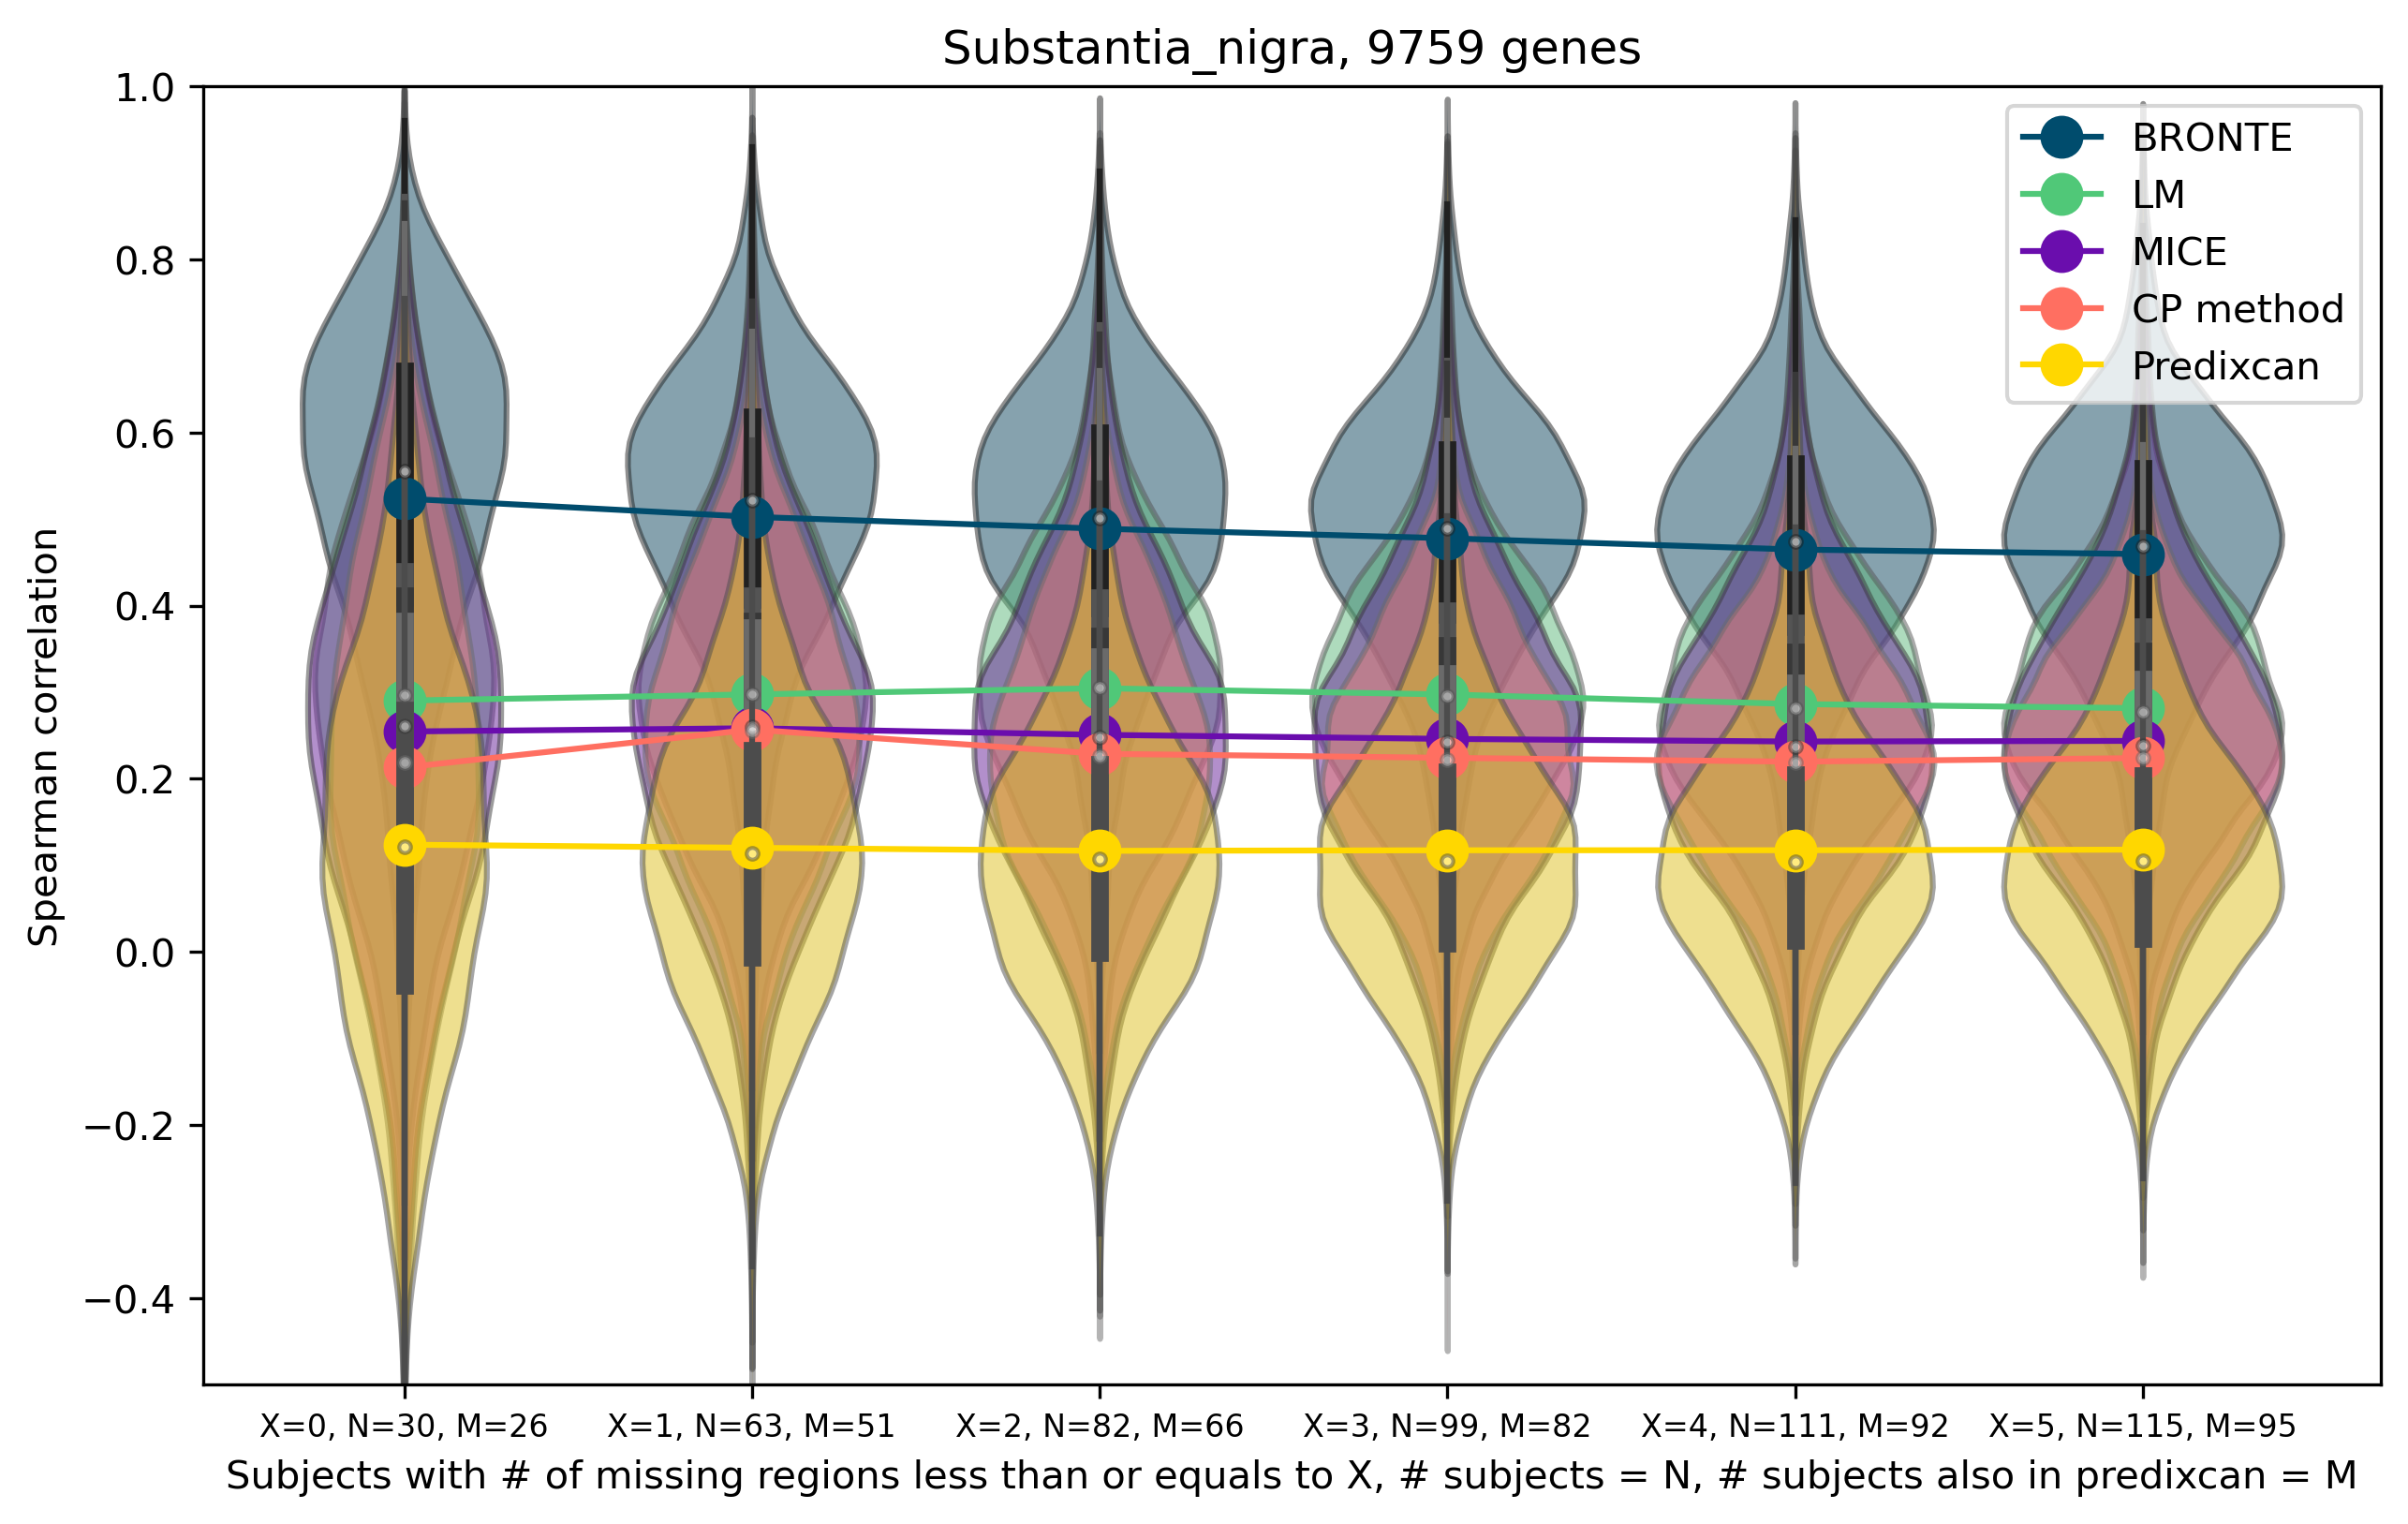

In [17]:
# Create violin plots
N_predixcan_gene = len(predixcan_matrix.index.tolist())
plt.figure(figsize=(10, 6), dpi=300)
colors = ['#004c6d', '#50c878', '#6a0dad', '#ff6f61', '#ffd700']
# GO model
x_values = [f"X={i}, N={n_subject[i]}, M={p_subject[i]}" for i in range(N) for _ in range(N_predixcan_gene)]
y_values = [val for sublist in go_cor_list_list for val in sublist]
sns.violinplot(x=x_values, y=y_values, color=colors[0], alpha=0.5)
plt.plot([x for x in range(N)], go_cor_means, marker='o', color=colors[0], linestyle='-', markersize=10, label='BRONTE')
# lm
y_values = [val for sublist in lm_cor_list_list for val in sublist]
sns.violinplot(x=x_values, y=y_values, color=colors[1], alpha=0.5)
plt.plot([x for x in range(N)], lm_cor_means, marker='o', color=colors[1], linestyle='-', markersize=10, label='LM')
# MICE
y_values = [val for sublist in mice_cor_list_list for val in sublist]
sns.violinplot(x=x_values, y=y_values, color=colors[2], alpha=0.5)
plt.plot([x for x in range(N)], mice_cor_means, marker='o', color=colors[2], linestyle='-', markersize=10, label='MICE')
# CP
y_values = [val for sublist in cp_cor_list_list for val in sublist]
sns.violinplot(x=x_values, y=y_values, color=colors[3], alpha=0.5)
plt.plot([x for x in range(N)], cp_cor_means, marker='o', color=colors[3], linestyle='-', markersize=10, label='CP method')
# Predixcan
y_values = [val for sublist in predixcan_cor_list_list for val in sublist]
sns.violinplot(x=x_values, y=y_values, color=colors[4], alpha=0.5)
plt.plot([x for x in range(N)], predixcan_cor_means, marker='o', color=colors[4], linestyle='-', markersize=10, label='Predixcan')

# modify the transparency
for obj in plt.gca().collections[:]:
    obj.set_alpha(0.5)
# Plot means for second set of violin plots
plt.title(f'{pred_region}, {len(predixcan_gene)} genes', fontsize=12)
plt.xlabel('Subjects with # of missing regions less than or equals to X, # subjects = N, # subjects also in predixcan = M', fontsize=10)
plt.ylabel('Spearman correlation', fontsize=10)
plt.xticks(fontsize=8)
plt.ylim(-0.5,1)
plt.legend()
plt.show()